<a href="https://colab.research.google.com/github/airoprojects/visiope/blob/main/experiments/test_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ai4MarsExperiments

#### Packages not included in colab

In [1]:
%pip install torchmetrics
%pip install ipywidgets
%pip install -e .
%pip install -U gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.1 MB/s eta 0:00:00
Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


## General imports

In [2]:
# General imports

import os
import sys
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics as metrics
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import ipywidgets as widgets
from IPython.display import display

## Custom Imports

In [3]:
# Custom Imports
import sys

COLAB = 'google.colab' in sys.modules
LOCAL = not COLAB

if COLAB:

    # Clone visiope repo on runtime env
    !git clone https://github.com/airoprojects/visiope.git /content/visiope/
    %cd ./visiope/
    !git checkout main
    !git branch
    %cd ../

    # Get the root directory of the Git project
    root_dir = '/content/visiope'

    # Add custom modules to path
    custom_modules_path = root_dir + '/tools/'
    sys.path.insert(0, custom_modules_path)

elif LOCAL:

    from git import Repo

    # Initialize the Git repository object
    repo = Repo(".", search_parent_directories=True)

    # Get the root directory of the Git project
    root_dir = repo.git.rev_parse("--show-toplevel")

    # Add custom modules to path
    custom_modules_path = root_dir  + '/tools/'
    sys.path.insert(0, custom_modules_path)


# Import Loader
from data.utils import Ai4MarsDownload, Ai4MarsImporter, Ai4MarsSplitter, Ai4MarsDataLoader

# Import Loss
from loss.loss import Ai4MarsCrossEntropy, Ai4MarsDiceLoss

# Import Trainer
from trainer.trainer import Ai4MarsTrainer

# Import Tester
from tester.tester import Ai4MarsTester

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cloning into '/content/visiope'...
remote: Enumerating objects: 1451, done.
remote: Counting objects: 100% (460/460), done.
remote: Compressing objects: 100% (255/255), done.
remote: Total 1451 (delta 223), reused 364 (delta 178), pack-reused 991
Receiving objects: 100% (1451/1451), 223.66 MiB | 27.36 MiB/s, done.
Resolving deltas: 100% (758/758), done.
/content/visiope
Already on 'main'
Your branch is up to date with 'origin/main'.
* main
/content


## Obtain dataset

#### Selecter functions

In [4]:
# get the whole dataset
def get_d(b):

    global num_images
    global data_path
    global selector
    global X
    global y

    # Cannot select anymore
    if not selector:
        print("Cannot select multiple options")
        return
    selector = False

    # Insert here your local path to the dataset (temporary)
    data_path = input("Path to Dataset: ")

    # Insert here the number of images you want to download
    num_images = int(input("Number of images (max 1000): "))

    # Import data as Ai4MarsDataset
    Ai4MarsDownload()(PATH=data_path)
    importer = Ai4MarsImporter()
    X, y, _ = importer(PATH=data_path, NUM_IMAGES=num_images, SIZE=128)

    pass

# Enable loading chunk of data
def enable_chunk(b):

    global selector
    global CHUNK
    global current_chunk

    # Cannot select anymore
    if not selector:
        print("Cannot select multiple options")
        return
    selector = False

    CHUNK = True
    current_chunk = 0

    # Download options
    d300 = widgets.Button(description="Dataset 300")
    d500 = widgets.Button(description="Dataset 500")
    d1k = widgets.Button(description="Dataset 1000")

    # Actions
    display(d300, d500, d1k)
    d300.on_click(get_d300)
    d500.on_click(get_d500)
    d1k.on_click(get_d1k)

    pass

#### Data download funtions

In [5]:
# ge the dataset in chncks of size 300
def get_d300(b):

    global COLAB
    global CHUNK
    global current_chunk
    global chunk_size
    global total_size
    global X
    global y

    # Cannot select anymore
    if not CHUNK:
        print("Cannot select multiple options")
        return

    chunk_size = 300
    total_size = 3000

    # update current chunk
    current_chunk += chunk_size

    print(f"Loading cunck {current_chunk // chunk_size}")

    if COLAB:

        if not(os.path.exists('/content/dataset/')):

            import gdown

            # get url of torch dataset (temporarerly my drive)
            drive = 'https://drive.google.com/uc?id='
            url = 'https://drive.google.com/drive/folders/1WaQKmnty99798t6b-GMh15GVy9ZxCkGP?usp=drive_link'

            !gdown --folder {url} -O /content/

            load_data = '/content/small-chunk-dataset/'

    elif LOCAL:
        load_data = root_dir + '/datasetup/small-chunk-dataset/'

    X, y = torch.load(load_data + str(current_chunk // chunk_size) + 'dataset.pt')

    print("Done")

    pass

# ge the dataset in chncks of size 500
def get_d500(b):

    global COLAB
    global CHUNK
    global current_chunk
    global chunk_size
    global total_size
    global X
    global y

    # Cannot select anymore
    if not CHUNK:
        print("Cannot select multiple options")
        return

    chunk_size = 500
    total_size = 5000

    # update current chunk
    current_chunk += chunk_size

    print(f"Loading cunck {current_chunk // chunk_size}")

    if COLAB:

        if not(os.path.exists('/content/dataset/')):

            import gdown

            # get url of torch dataset (temporarerly my drive)
            drive = 'https://drive.google.com/uc?id='
            url = 'https://drive.google.com/drive/folders/1u4imSO8MerdZEW0V1lkEb6PWQmZgT5Ft?usp=sharing'

            !gdown --folder {url} -O /content/

            load_data = '/content/medium-chunk-dataset/'

    elif LOCAL:
        load_data = root_dir + '/datasetup/medium-chunk-dataset/'

    X, y = torch.load(load_data + str(current_chunk // chunk_size) + 'dataset.pt')

    print("Done")
    pass

# ge the dataset in chncks of size 1k
def get_d1k(b):

    global COLAB
    global CHUNK
    global current_chunk
    global chunk_size
    global total_size
    global X
    global y

    # Cannot select anymore
    if not CHUNK:
        print("Cannot select multiple options")
        return

    chunk_size = 1000
    total_size = 10000

    print(f"Loading cunck {current_chunk // chunk_size}")

    # update current chunk
    current_chunk += chunk_size

    if COLAB:

        if not(os.path.exists('/content/dataset/')):

            import gdown

            # get url of torch dataset (temporarerly my drive)
            drive = 'https://drive.google.com/uc?id='
            url = 'https://drive.google.com/drive/folders/1BhL0nLbQt930l_ISDgUS8ZJRWGjH4eUU?usp=sharing'

            !gdown --folder {url} -O /content/

            load_data = '/content/chunk-dataset/'

    elif LOCAL:
        load_data = root_dir + '/datasetup/chunk-dataset/'

    X, y = torch.load(load_data + 'dataset_' + str(current_chunk) + '.pt')

    pass

#### Selector

In [ ]:
# Select import mode

# ENV VARIABLE INITIALIZATION DO NOT CHANGE
CHUNK = False
current_chunk = 0
chunk_size = 0
total_size = 0
X = 0
y = 0

# Allow to select only one option
if 'selector' not in globals():
    selector  = True

# Selection buttons
d = widgets.Button(description="Load whole Dataset")
chunk = widgets.Button(description="Load chunk of data")


# actions
display(d, chunk)
d.on_click(get_d)
chunk.on_click(enable_chunk)


In [ ]:
# HARD RESET
# selector = True
# CHUNK = False

## DataLoader

In [7]:
transform = None
# Uncomment the following lines to apply transformations to the dataset
'''
transform = transforms.RandomChoice([
    transforms.RandomRotation(90)])
'''

# Split the dataset
splitter = Ai4MarsSplitter()
percentages = [0.7, 0.2, 0.1]
train_set, test_set, val_set = splitter(X, y, percentages, transform=transform)

# Load info
load_info = './.info.pt'
info = torch.load(load_info)

# Build Ai4MarsDataloader
loader = Ai4MarsDataLoader()
batch_sizes = [32, 16, 16]
datasets = [train_set, test_set, val_set]
train_loader, test_loader, val_loader = loader(datasets, batch_sizes)

Splitting parameters: 
             Dataset: ai4mars-dataset-merged-0.1 
             Colab environment: True 
             Split percentages: [0.7, 0.2, 0.1] 
             Transformation: None 
             Svaving path: None 
             New image size: 128
Extrapolation of random inices ...
Splitting in progress ...
Done 

Building Dataloaders
Done 



Len of train set: 560
Len of test set: 160
Len of validation set: 80
image shape: torch.Size([128, 128, 3])


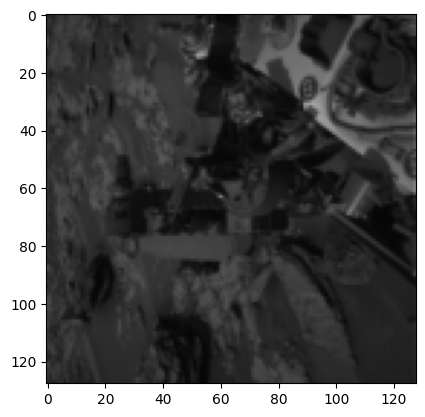

image shape: torch.Size([128, 128, 1])


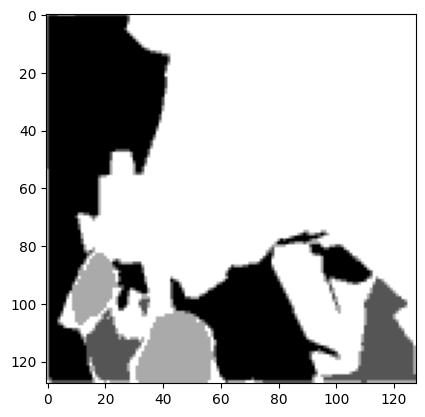

In [8]:
# Just to check that different chunks contains different images
import matplotlib.pyplot as plt

print(f'Len of train set: {len(train_set)}')
print(f'Len of test set: {len(test_set)}')
print(f'Len of validation set: {len(val_set)}')

image, label = X[0], y[0]

print(f'image shape: {image.permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(image.permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

print(f'image shape: {label.permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(label.permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

# Free up mem
del X
del y

## Model setup

In [12]:
# Clone remote repo with existing models

if COLAB:
    !git clone https://github.com/sithu31296/semantic-segmentation
    %pip install -e .
    %pip install -U gdown
    %cd semantic-segmentation

Cloning into 'semantic-segmentation'...
remote: Enumerating objects: 792, done.
remote: Counting objects: 100% (789/789), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 792 (delta 479), reused 749 (delta 470), pack-reused 3
Receiving objects: 100% (792/792), 54.99 MiB | 10.15 MiB/s, done.
Resolving deltas: 100% (479/479), done.
Obtaining file:///content/semantic-segmentation
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61405 sha256=af75495bfa811b3c969935dfe845aed9ee3978299f4f1af4a7d61e04f0a24709
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42

In [13]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  Lawin
    3  SFNet
    4  BiSeNetv1
    5  DDRNet
    6  FCHarDNet
    7  BiSeNetv2


In [15]:
#  Import segformer

from semseg.models import *

model = eval('Lawin')(
    backbone='MiT-B2',
    num_classes=5
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth',
                                     map_location=device))
    print("Pretrained model's weights downloaded")
except:
    print("Download a pretrained model's weights from the result table.")

model.to(device)

print('Loaded Model')
%cd /content/

Download a pretrained model's weights from the result table.
Loaded Model
/content


## Training

#### Training parameters

In [16]:
# Training parameters

loss_fn = Ai4MarsDiceLoss().to(device)
#loss_fn = Ai4MarsCrossEntropy().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

transform = None
# transform = transforms.RandomChoice([
#      transforms.RandomRotation(90)])

epochs = 10

trainer = Ai4MarsTrainer(loss_fn, optimizer, train_loader, val_loader,
                         transform=transform, device=device, info=info, model_name='MiT-B2', dump=True)

Data will be saved in ./dump/20230718-152735-MiT-B2/hist/


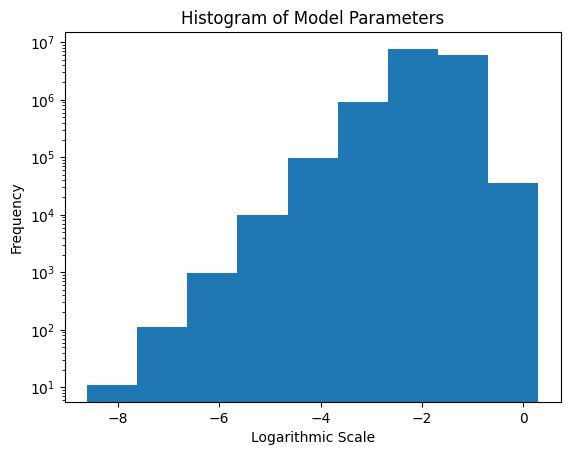

In [17]:
# Model Parameters
# Check if the variable has been defined
if 'run_once' not in globals():
    run_once = True
    trainer.param_hist(model, label='before')

#### Regular training

In [18]:
# Start training
trainer.train_multiple_epoch(model, EPOCHS=epochs)

EPOCH 1
Train loss: 0.6548571520381503
Time needed for training: 59.29989171028137 seconds
Validation loss: 0.5245582580566406 

EPOCH 2
Train loss: 0.607051455312305
Time needed for training: 51.94951105117798 seconds
Validation loss: 0.5621886372566223 

EPOCH 3
Train loss: 0.5608851843410068
Time needed for training: 51.99824118614197 seconds
Validation loss: 0.5245582580566406 

EPOCH 4
Train loss: 0.5961819258001115
Time needed for training: 52.10985517501831 seconds
Validation loss: 0.5191272616386413 

EPOCH 5
Train loss: 0.5882840388351016
Time needed for training: 51.536810874938965 seconds
Validation loss: 0.5245582580566406 

EPOCH 6
Train loss: 0.5555587609608968
Time needed for training: 51.81817078590393 seconds
Validation loss: 0.6031564593315124 

EPOCH 7
Train loss: 0.5406071874830458
Time needed for training: 52.16671323776245 seconds
Validation loss: 0.733256459236145 

EPOCH 8
Train loss: 0.5658269921938578
Time needed for training: 51.94313597679138 seconds
Validat

#### Chunk training

In [25]:
if not CHUNK:
    print("You are not allowd to perform chunk training proceede with regular traiing")

else:

    print("You are allowd to perform chunk training proceede with regular traiing")
    print("Please pay attention that you are using the same splitting parameters")

    CHUNK = False
    stop_at = (total_size // chunk_size) - 1

    for i in range(0, stop_at):

        if i == 0:
            print(f"Loading chunck {current_chunk // chunk_size}")
            trainer.train_multiple_epoch(model, EPOCHS=epochs)

        else:

            # update current chunk
            current_chunk += chunk_size

            print(f"Loading chunck {current_chunk // chunk_size}")

            if COLAB: load_data = '/content/medium-chunk-dataset/'
            elif LOCAL: load_data = root_dir + '/datasetup/medium-chunk-dataset/'

            X, y = torch.load(load_data + str(current_chunk // chunk_size) + 'dataset.pt')

            # Build dataset
            splitter = Ai4MarsSplitter()
            train_set, test_set, val_set = splitter(X, y, percentages)

            # Build Ai4MarsDataloader
            loader = Ai4MarsDataLoader()
            train_loader, test_loader, val_loader = loader(
                [train_set, test_set, val_set], batch_sizes)

            trainer.train_multiple_epoch(model, EPOCHS=epochs)

You are allowd to perform chunk training proceede with regular traiing
Please pay attention that you are using the same splitting parameters
Loading cunck 4
Splitting parameters: 
             Dataset: ai4mars-dataset-merged-0.1 
             Colab environment: True 
             Split percentages: [0.7, 0.2, 0.1] 
             Transformation: None 
             Svaving path: None 
             New image size: 128
Extrapolation of random inices ...
Splitting in progress ...
Done 

Building Dataloaders
Done 

{'dataset': 'ai4mars-dataset-merged-0.1', 'percentages': '[0.7, 0.2, 0.1]', 'transform': None, 'size': '128'}
EPOCH 1
Train loss: 0.5467303627067142
Time needed for training: 52.653889179229736 seconds
Validation loss: 0.5245582580566406 

EPOCH 2
Train loss: 0.5415814883179135
Time needed for training: 52.15882968902588 seconds
Validation loss: 0.5245582580566406 

EPOCH 3
Train loss: 0.5414601829316881
Time needed for training: 52.10629463195801 seconds
Validation loss: 0.5014569

FileNotFoundError: ignored

#### Plot loss

Data will be saved in ./dump/20230718-152735-MiT-B2/loss/


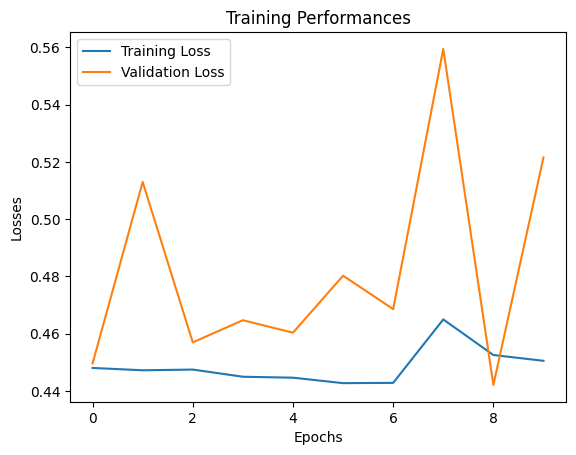

Train mean loss: 0.44855913619200394
Validation mean loss: 0.4816474437713623


In [26]:
# Plot loss

import matplotlib.pyplot as plt

trainer.plot_loss()

## Testing

In [27]:
# Testing and evaluation Metrics

metric = metrics.JaccardIndex(task="multiclass", num_classes=5).to(device)
tester = Ai4MarsTester(loss_fn, metric, test_loader, device=device)

In [28]:
# Start testing

tester.test_one_epoch(model)

Test loss: 0.5590202552931649

Metrics MulticlassJaccardIndex(): 0.5177204012870789


Data will be saved in ./dump/20230718-152735-MiT-B2/hist/


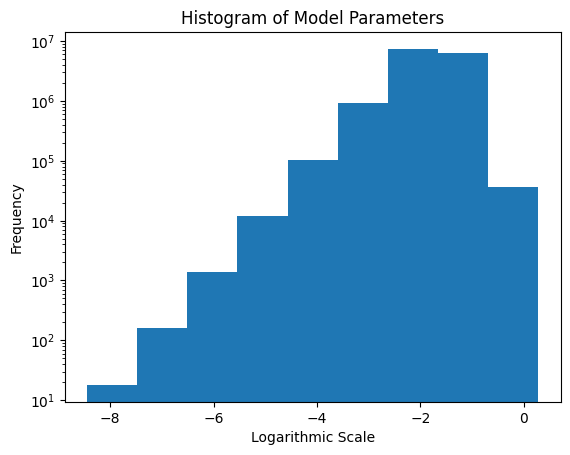

In [29]:
# Module Parameters
trainer.param_hist(model, label='after')

In [ ]:
model.eval()

for i, batch in enumerate(test_loader):
  image, label = batch
  print(image.shape)
  pred = model(image.to(device))
  tester.show_images(image, trainer.results_path, index=i)
  tester.show_seg(label, trainer.results_path, index=i)
  tester.show_seg(pred.cpu(), trainer.results_path, index=i)

In [ ]:
# To save file once you trained
!zip -r 20230718-152735-MiT-B2-2.zip /content/dump/20230718-152735-MiT-B2
from google.colab import files

#files to save
files.download("/content/dump/20230718-152735-MiT-B2.zip")